In [903]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset


import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from mtcnn import MTCNN
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model


In [904]:
# GLOBAL VARS
training_size_perc = 1
epochs = 2
lr_scene_reduction = 0.0001
lr_faces = 0.0001
lr_scenes = 0.0001
lr_model = 0.0001
batch_size = 16

In [905]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
df = pd.read_pickle(os.path.join(data_dir, "dataframe_cleaned.pkl"))

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog


In [906]:
# set device, move models and maps, set eval mode
device = torch.device("cpu")

In [907]:
emotion_categories_hf = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]

EMO8_LIST = [l[1] for l in EMOTION_SETS]

In [908]:
# Apply the mapping to 8 emotions as defined in the FindingEmo code
EMO8_MAPPING = {}

for i, leaf in enumerate(EMOTION_SETS):
    for emo in leaf:
        EMO8_MAPPING[emo] = EMO8_LIST[i]

In [909]:
# get the different emo8's  
basic_6_emotions = ["Anger", "Disgust", "Fear", "Joy", "Sadness", "Surprise"]
basic_6_emotions_idx = {emo: i for i, emo in enumerate(basic_6_emotions)}

In [910]:
basic_6_emotions_idx

{'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Joy': 3, 'Sadness': 4, 'Surprise': 5}

In [911]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]

In [912]:
scene_categories

['airfield',
 'airplane_cabin',
 'airport_terminal',
 'alcove',
 'alley',
 'amphitheater',
 'amusement_arcade',
 'amusement_park',
 'apartment_building_outdoor',
 'aquarium',
 'aqueduct',
 'arcade',
 'arch',
 'archaelogical_excavation',
 'archive',
 'arena_hockey',
 'arena_performance',
 'arena_rodeo',
 'army_base',
 'art_gallery',
 'art_school',
 'art_studio',
 'artists_loft',
 'assembly_line',
 'athletic_field_outdoor',
 'atrium_public',
 'attic',
 'auditorium',
 'auto_factory',
 'auto_showroom',
 'badlands',
 'bakery_shop',
 'balcony_exterior',
 'balcony_interior',
 'ball_pit',
 'ballroom',
 'bamboo_forest',
 'bank_vault',
 'banquet_hall',
 'bar',
 'barn',
 'barndoor',
 'baseball_field',
 'basement',
 'basketball_court_indoor',
 'bathroom',
 'bazaar_indoor',
 'bazaar_outdoor',
 'beach',
 'beach_house',
 'beauty_salon',
 'bedchamber',
 'bedroom',
 'beer_garden',
 'beer_hall',
 'berth',
 'biology_laboratory',
 'boardwalk',
 'boat_deck',
 'boathouse',
 'bookstore',
 'booth_indoor',
 'b

In [913]:
places365_to_13categories = {
    # --- Transport infrastructure ---
    "airfield": "transport_infrastructure",
    "airplane_cabin": "transport_infrastructure",
    "airport_terminal": "transport_infrastructure",
    "railroad_track": "transport_infrastructure",
    "train_interior": "transport_infrastructure",
    "train_station_platform": "transport_infrastructure",
    "subway_station_platform": "transport_infrastructure",
    "bridge": "transport_infrastructure",
    "runway": "transport_infrastructure",
    "highway": "transport_infrastructure",
    "garage_indoor": "transport_infrastructure",
    "garage_outdoor": "transport_infrastructure",
    "bus_interior": "transport_infrastructure",
    "bus_station_indoor": "transport_infrastructure",
    "harbor": "transport_infrastructure",
    "viaduct": "transport_infrastructure",
    "heliport": "transport_infrastructure",
    "parking_garage_indoor": "transport_infrastructure",
    "parking_garage_outdoor": "transport_infrastructure",
    "car_interior": "transport_infrastructure",
    "cockpit": "transport_infrastructure",
    "berth": "transport_infrastructure",

    # --- Indoor residential ---
    "bedroom": "indoor_residential",
    "bathroom": "indoor_residential",
    "living_room": "indoor_residential",
    "kitchen": "indoor_residential",
    "attic": "indoor_residential",
    "childs_room": "indoor_residential",
    "closet": "indoor_residential",
    "dining_room": "indoor_residential",
    "dorm_room": "indoor_residential",
    "hotel_room": "indoor_residential",
    "mansion": "indoor_residential",
    "nursery": "indoor_residential",
    "television_room": "indoor_residential",
    "pantry": "indoor_residential",
    "playroom": "indoor_residential",
    "house": "indoor_residential",
    "apartment_building_outdoor": "indoor_residential",
    "balcony_interior": "indoor_residential",
    "banquet_hall": "indoor_residential",
    "porch": "indoor_residential",
    "jacuzzi_indoor": "indoor_residential",
    "shower": "indoor_residential",
    "alcove": "indoor_residential",
    "bedchamber": "indoor_residential",
    "ballroom": "indoor_residential",
    "basement": "indoor_residential",
    "dressing_room": "indoor_residential",
    "home_office": "indoor_residential",
    "home_theater": "indoor_residential",
    "manufactured_home": "indoor_residential",
    "utility_room": "indoor_residential",
    "wet_bar": "indoor_residential",
    "youth_hostel": "indoor_residential",

    # --- Indoor commercial ---
    "bakery_shop": "indoor_commercial",
    "bar": "indoor_commercial",
    "bookstore": "indoor_commercial",
    "butchers_shop": "indoor_commercial",
    "candy_store": "indoor_commercial",
    "clothing_store": "indoor_commercial",
    "department_store": "indoor_commercial",
    "fastfood_restaurant": "indoor_commercial",
    "florist_shop_indoor": "indoor_commercial",
    "gift_shop": "indoor_commercial",
    "jewelry_shop": "indoor_commercial",
    "market_indoor": "indoor_commercial",
    "pet_shop": "indoor_commercial",
    "pharmacy": "indoor_commercial",
    "shoe_shop": "indoor_commercial",
    "shopping_mall_indoor": "indoor_commercial",
    "supermarket": "indoor_commercial",
    "toyshop": "indoor_commercial",
    "restaurant": "indoor_commercial",
    "restaurant_kitchen": "indoor_commercial",
    "restaurant_patio": "indoor_commercial",
    "pizzeria": "indoor_commercial",
    "pub_indoor": "indoor_commercial",
    "sushi_bar": "indoor_commercial",
    "hotel_outdoor": "indoor_commercial",
    "amusement_arcade": "indoor_commercial",
    "auto_showroom": "indoor_commercial",
    "bakery_shop": "indoor_commercial",
    "bank_vault": "indoor_commercial",
    "bazaar_indoor": "indoor_commercial",
    "beauty_salon": "indoor_commercial",
    "cafeteria": "indoor_commercial",
    "coffee_shop": "indoor_commercial",
    "delicatessen": "indoor_commercial",
    "discotheque": "indoor_commercial",
    "drugstore": "indoor_commercial",
    "fabric_store": "indoor_commercial",
    "flea_market_indoor": "indoor_commercial",
    "food_court": "indoor_commercial",
    "hardware_store": "indoor_commercial",
    "laundromat": "indoor_commercial",
    "market_outdoor": "indoor_commercial",
    "motel": "indoor_commercial",
    "pub_indoor": "indoor_commercial",
    "sauna": "indoor_commercial",
    "server_room": "indoor_commercial",
    "shoe_shop": "indoor_commercial",
    "shopping_mall_indoor": "indoor_commercial",
    "supermarket": "indoor_commercial",
    "booth_indoor": "indoor_commercial",
    "ice_cream_parlor": "indoor_commercial",
    "general_store_indoor": "indoor_commercial",
    "general_store_outdoor": "indoor_commercial",
    "pavilion": "indoor_commercial",
    "ticket_booth": "indoor_commercial",

    # --- Indoor institutional ---
    "art_gallery": "indoor_institutional",
    "auditorium": "indoor_institutional",
    "church_indoor": "indoor_institutional",
    "classroom": "indoor_institutional",
    "conference_room": "indoor_institutional",
    "hospital": "indoor_institutional",
    "hospital_room": "indoor_institutional",
    "library_indoor": "indoor_institutional",
    "lecture_room": "indoor_institutional",
    "office": "indoor_institutional",
    "office_cubicles": "indoor_institutional",
    "schoolhouse": "indoor_institutional",
    "science_museum": "indoor_institutional",
    "nursing_home": "indoor_institutional",
    "reception": "indoor_institutional",
    "waiting_room": "indoor_institutional",
    "museum_indoor": "indoor_institutional",
    "biology_laboratory": "indoor_institutional",
    "chemistry_lab": "indoor_institutional",
    "clean_room": "indoor_institutional",
    "conference_center": "indoor_institutional",
    "courthouse": "indoor_institutional",
    "embassy": "indoor_institutional",
    "entrance_hall": "indoor_institutional",
    "elevator_lobby": "indoor_institutional",
    "elevator_shaft": "indoor_institutional",
    "elevator_door": "indoor_institutional",
    "escalator_indoor": "indoor_institutional",
    "hospital": "indoor_institutional",
    "kindergarden_classroom": "indoor_institutional",
    "legislative_chamber": "indoor_institutional",
    "library_outdoor": "indoor_institutional",
    "lobby": "indoor_institutional",
    "locker_room": "indoor_institutional",
    "operating_room": "indoor_institutional",
    "physics_laboratory": "indoor_institutional",
    "recreation_room": "indoor_institutional",
    "veterinarians_office": "indoor_institutional",
    "atrium_public": "indoor_institutional",
    "corridor": "indoor_institutional",
    "computer_room": "indoor_institutional",
    "mezzanine": "indoor_institutional",
    "office_building": "indoor_institutional",
    "jail_cell": "indoor_institutional",
    "storage_room": "indoor_institutional",

    # --- Industrial facilities ---
    "assembly_line": "industrial_facility",
    "auto_factory": "industrial_facility",
    "engine_room": "industrial_facility",
    "industrial_area": "industrial_facility",
    "oilrig": "industrial_facility",
    "construction_site": "industrial_facility",
    "army_base": "industrial_facility",
    "junkyard": "industrial_facility",
    "repair_shop": "industrial_facility",
    "loading_dock": "industrial_facility",
    "fire_station": "industrial_facility",
    "landing_deck": "industrial_facility",
    "construction_site": "industrial_facility",
    "gas_station": "industrial_facility",
    "hangar_indoor": "industrial_facility",
    "hangar_outdoor": "industrial_facility",
    "dam": "industrial_facility",
    "excavation": "industrial_facility",
    "fire_escape": "industrial_facility",
    "landfill": "industrial_facility",
    "lock_chamber": "industrial_facility",
    "trench": "industrial_facility",
    "shed": "industrial_facility",

    # --- Urban outdoor ---
    "alley": "urban_outdoor",
    "building_facade": "urban_outdoor",
    "courtyard": "urban_outdoor",
    "crosswalk": "urban_outdoor",
    "downtown": "urban_outdoor",
    "plaza": "urban_outdoor",
    "street": "urban_outdoor",
    "shopfront": "urban_outdoor",
    "parking_lot": "urban_outdoor",
    "residential_neighborhood": "urban_outdoor",
    "skyscraper": "urban_outdoor",
    "amusement_park": "urban_outdoor",
    "arcade": "urban_outdoor",
    "balcony_exterior": "urban_outdoor",
    "bazaar_outdoor": "urban_outdoor",
    "boardwalk": "urban_outdoor",
    "driveway": "urban_outdoor",
    "doorway_outdoor": "urban_outdoor",
    "gazebo_exterior": "urban_outdoor",
    "market_outdoor": "urban_outdoor",
    "patio": "urban_outdoor",
    "plaza": "urban_outdoor",
    "promenade": "urban_outdoor",
    "rope_bridge": "urban_outdoor",
    "street": "urban_outdoor",
    "tower": "urban_outdoor",
    "slum": "urban_outdoor",
    "sky": "urban_outdoor",
    "roof_garden": "urban_outdoor",
    "phone_booth": "urban_outdoor",

    # --- Natural landscapes ---
    "badlands": "natural_landscape",
    "canyon": "natural_landscape",
    "cliff": "natural_landscape",
    "desert_sand": "natural_landscape",
    "desert_vegetation": "natural_landscape",
    "forest_broadleaf": "natural_landscape",
    "forest_path": "natural_landscape",
    "mountain": "natural_landscape",
    "mountain_path": "natural_landscape",
    "mountain_snowy": "natural_landscape",
    "valley": "natural_landscape",
    "volcano": "natural_landscape",
    "rock_arch": "natural_landscape",
    "rainforest": "natural_landscape",
    "bamboo_forest": "natural_landscape",
    "butte": "natural_landscape",
    "canal_natural": "natural_landscape",
    "cliff": "natural_landscape",
    "coast": "natural_landscape",
    "creek": "natural_landscape",
    "crevasse": "natural_landscape",
    "desert_road": "natural_landscape",
    "field_road": "natural_landscape",
    "forest_road": "natural_landscape",
    "grotto": "natural_landscape",
    "islet": "natural_landscape",
    "lawn": "natural_landscape",
    "marsh": "natural_landscape",
    "swamp": "natural_landscape",
    "vegetable_garden": "natural_landscape",
    "wheat_field": "natural_landscape",
    "wind_farm": "natural_landscape",
    "windmill": "natural_landscape",
    "zen_garden": "natural_landscape",
    "canal_urban": "natural_landscape",
    "fountain": "natural_landscape",

    # --- Cold environments ---
    "ice_floe": "cold_environment",
    "ice_shelf": "cold_environment",
    "iceberg": "cold_environment",
    "igloo": "cold_environment",
    "ski_resort": "cold_environment",
    "ski_slope": "cold_environment",
    "snowfield": "cold_environment",
    "tundra": "cold_environment",
    "glacier": "cold_environment",

    # --- Aquatic environments ---
    "aquarium": "aquatic_environment",
    "beach": "aquatic_environment",
    "boat_deck": "aquatic_environment",
    "boathouse": "aquatic_environment",
    "harbor": "aquatic_environment",
    "lake_natural": "aquatic_environment",
    "lagoon": "aquatic_environment",
    "ocean": "aquatic_environment",
    "pond": "aquatic_environment",
    "river": "aquatic_environment",
    "waterfall": "aquatic_environment",
    "swimming_pool_indoor": "aquatic_environment",
    "swimming_pool_outdoor": "aquatic_environment",
    "swimming_hole": "aquatic_environment",
    "hot_spring": "aquatic_environment",
    "beach_house": "aquatic_environment",
    "fishpond": "aquatic_environment",
    "moat_water": "aquatic_environment",
    "pier": "aquatic_environment",
    "raft": "aquatic_environment",
    "watering_hole": "aquatic_environment",
    "wave": "aquatic_environment",
    "water_tower": "aquatic_environment",
    "underwater_ocean_deep": "aquatic_environment",
    "lighthouse": "aquatic_environment",


    # --- Religious or historical sites ---
    "church_outdoor": "religious_or_historical_site",
    "mosque_outdoor": "religious_or_historical_site",
    "synagogue_outdoor": "religious_or_historical_site",
    "temple_asia": "religious_or_historical_site",
    "catacomb": "religious_or_historical_site",
    "mausoleum": "religious_or_historical_site",
    "palace": "religious_or_historical_site",
    "castle": "religious_or_historical_site",
    "ruin": "religious_or_historical_site",
    "arch": "religious_or_historical_site",
    "amphitheater": "religious_or_historical_site",
    "archaelogical_excavation": "religious_or_historical_site",
    "burial_chamber": "religious_or_historical_site",
    "cemetery": "religious_or_historical_site",
    "chalet": "religious_or_historical_site",
    "kasbah": "religious_or_historical_site",
    "medina": "religious_or_historical_site",
    "pagoda": "religious_or_historical_site",
    "throne_room": "religious_or_historical_site",

    # --- Sports and entertainment ---
    "arena_hockey": "sports_and_entertainment",
    "arena_performance": "sports_and_entertainment",
    "arena_rodeo": "sports_and_entertainment",
    "baseball_field": "sports_and_entertainment",
    "basketball_court_indoor": "sports_and_entertainment",
    "boxing_ring": "sports_and_entertainment",
    "football_field": "sports_and_entertainment",
    "gymnasium_indoor": "sports_and_entertainment",
    "martial_arts_gym": "sports_and_entertainment",
    "racecourse": "sports_and_entertainment",
    "stadium_football": "sports_and_entertainment",
    "stadium_soccer": "sports_and_entertainment",
    "stage_indoor": "sports_and_entertainment",
    "stage_outdoor": "sports_and_entertainment",
    "bowling_alley": "sports_and_entertainment",
    "movie_theater_indoor": "sports_and_entertainment",
    "amphitheater": "sports_and_entertainment",
    "athletic_field_outdoor": "sports_and_entertainment",
    "ball_pit": "sports_and_entertainment",
    "baseball_field": "sports_and_entertainment",
    "basketball_court_indoor": "sports_and_entertainment",
    "bow_window_indoor": "sports_and_entertainment",
    "boxing_ring": "sports_and_entertainment",
    "bullring": "sports_and_entertainment",
    "football_field": "sports_and_entertainment",
    "raceway": "sports_and_entertainment",
    "soccer_field": "sports_and_entertainment",
    "stadium_baseball": "sports_and_entertainment",
    "staircase": "sports_and_entertainment",
    "topiary_garden": "sports_and_entertainment",
    "water_park": "sports_and_entertainment",
    "carrousel": "sports_and_entertainment",
    "dining_hall": "sports_and_entertainment",
    "diner_outdoor": "sports_and_entertainment",
    "ice_skating_rink_indoor": "sports_and_entertainment",
    "ice_skating_rink_outdoor": "sports_and_entertainment",


    # --- Cultural spaces ---
    "art_studio": "cultural_space",
    "art_school": "cultural_space",
    "music_studio": "cultural_space",
    "television_studio": "cultural_space",
    "museum_outdoor": "cultural_space",
    "artists_loft": "cultural_space",
    "archive": "cultural_space",
    "galley": "cultural_space",
    "japanese_garden": "cultural_space",
    "natural_history_museum": "cultural_space",
    "music_studio": "cultural_space",
    "orchestra_pit": "cultural_space",

    # --- Rural or recreational area ---
    "aqueduct": "rural_or_recreational_area",
    "barn": "rural_or_recreational_area",
    "barndoor": "rural_or_recreational_area",
    "beer_garden": "rural_or_recreational_area",
    "beer_hall": "rural_or_recreational_area",
    "botanical_garden": "rural_or_recreational_area",
    "cabin_outdoor": "rural_or_recreational_area",
    "campsite": "rural_or_recreational_area",
    "campus": "rural_or_recreational_area",
    "farm": "rural_or_recreational_area",
    "field_cultivated": "rural_or_recreational_area",
    "field_wild": "rural_or_recreational_area",
    "golf_course": "rural_or_recreational_area",
    "greenhouse_outdoor": "rural_or_recreational_area",
    "hayfield": "rural_or_recreational_area",
    "orchard": "rural_or_recreational_area",
    "park": "rural_or_recreational_area",
    "pasture": "rural_or_recreational_area",
    "picnic_area": "rural_or_recreational_area",
    "playground": "rural_or_recreational_area",
    "rice_paddy": "rural_or_recreational_area",
    "sandbox": "rural_or_recreational_area",
    "stable": "rural_or_recreational_area",
    "tree_farm": "rural_or_recreational_area",
    "tree_house": "rural_or_recreational_area",
    "village": "rural_or_recreational_area",
    "vineyard": "rural_or_recreational_area",
    "volleyball_court_outdoor": "rural_or_recreational_area",
    "yard": "rural_or_recreational_area",
    "corn_field": "rural_or_recreational_area",
    "corral": "rural_or_recreational_area",
    "cottage": "rural_or_recreational_area",
    "formal_garden": "rural_or_recreational_area",
    "greenhouse_indoor": "rural_or_recreational_area",
    "hunting_lodge_outdoor": "rural_or_recreational_area",
    "inn_outdoor": "rural_or_recreational_area",
    "kennel_outdoor": "rural_or_recreational_area",
    "pavilion": "rural_or_recreational_area",
    "oast_house": "rural_or_recreational_area",
}


In [914]:
categories_13 = list(set(places365_to_13categories.values()))
categories_13

['natural_landscape',
 'industrial_facility',
 'urban_outdoor',
 'indoor_residential',
 'religious_or_historical_site',
 'sports_and_entertainment',
 'cultural_space',
 'transport_infrastructure',
 'aquatic_environment',
 'cold_environment',
 'indoor_institutional',
 'rural_or_recreational_area',
 'indoor_commercial']

In [915]:
from collections import defaultdict

# Let's build a mapping from 365 index to 13 index
map_365_to_13 = torch.zeros((365, 13))
for i, cat in enumerate(scene_categories):
    coarse = places365_to_13categories[cat]
    coarse_idx = categories_13.index(coarse)
    map_365_to_13[i, coarse_idx] = 1

In [916]:
map_365_to_13[17,:]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [917]:
scene_categories[17]

'arena_rodeo'

In [918]:
# Now create train/test splits with clean data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)
print("Training set shape: ",df_train.shape)
print("Test set shape: ",df_test.shape)

Training set shape:  (13135, 10)
Test set shape:  (3284, 10)


In [919]:
df_train.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,emotion_8,emotion_8_idx
0,Run_2/Heated forty-something ceremony/e23f81ea...,Undefined,"Children,Youth,Adults,Seniors",-3,4,Sadness,"Context,FacialExpression,Staging",0,Sadness,4
1,Run_2/Cheerful youth theater/home-students.jpg,Undefined,Young Adults,1,2,Serenity,"Neutral,FacialExpression",2,Joy,0
2,Run_2/Aggressive toddlers soccer/PRI214619698.jpg,Undefined,Adults,-1,2,Anger,"Context,FacialExpression",2,Anger,6
3,Run_2/Fuming elderly party/uttam3.jpg,Undefined,"Young Adults,Adults,Seniors",-1,2,Apprehension,"BodyLanguage,Staging",5,Fear,2
4,Run_2/Somber students funeral/urn-publicid-ap-...,Undefined,"Adults,Seniors",-1,4,Pensiveness,"BodyLanguage,Context,FacialExpression",5,Sadness,4


In [920]:
def show_image(df, index):
    img_path = os.path.join(findingemo_dir, df.loc[index, 'image_path'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

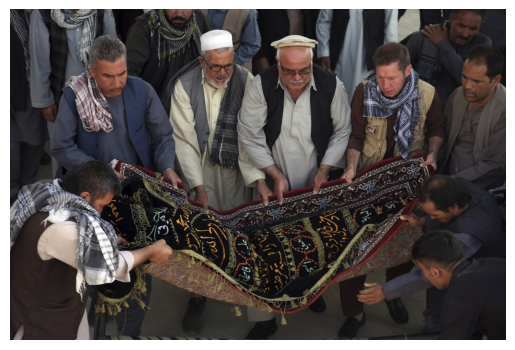

In [921]:
show_image(df_train, 4)

In [922]:
face_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

face_detector = MTCNN()

scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model.load_state_dict(state_dict)

print("Loaded pretrained models")

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


Loaded pretrained models


In [923]:
scene_model.to(device)
scene_model.eval()

face_model.to(device)
face_model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [924]:
class TruncatedFaceModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        face_output = self.model(x)
        face_logits = face_output.logits[:, :6]
        face_probs = torch.softmax(face_logits, dim=1)
        return face_probs

face_model_truncated = TruncatedFaceModel(face_model)
face_model_truncated.to(device)
face_network = Network(face_model_truncated, "face_model", batching = True)
face_network.optimizer = torch.optim.Adam(face_network.parameters(), lr=lr_faces)

In [925]:
class TruncatedSceneModel(nn.Module):
    def __init__(self, model, map_365_to_13 = map_365_to_13):
        super().__init__()
        self.model = model
        self.register_buffer("map_365_to_13", map_365_to_13)

    def forward(self, x):
        device = next(self.model.parameters()).device
        x = x.to(device)
        logits_365 = self.model(x)
        probs_365 = torch.softmax(logits_365, dim=1)
        probs_13 = torch.matmul(probs_365, self.map_365_to_13)
        return probs_13
    
scene_model_truncated = TruncatedSceneModel(scene_model)
scene_model_truncated.to(device)
scene_network = Network(scene_model_truncated, "scene_model", batching = True)
scene_network.optimizer = torch.optim.Adam(scene_network.parameters(), lr=lr_scenes)

In [926]:
def display_tensor_as_image(tensor):
    tensor = tensor.squeeze(0)
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    array = tensor.permute(1, 2, 0).numpy()
    plt.imshow(array)
    plt.axis('off')
    plt.show()

In [927]:
df_train.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,emotion_8,emotion_8_idx
0,Run_2/Heated forty-something ceremony/e23f81ea...,Undefined,"Children,Youth,Adults,Seniors",-3,4,Sadness,"Context,FacialExpression,Staging",0,Sadness,4
1,Run_2/Cheerful youth theater/home-students.jpg,Undefined,Young Adults,1,2,Serenity,"Neutral,FacialExpression",2,Joy,0
2,Run_2/Aggressive toddlers soccer/PRI214619698.jpg,Undefined,Adults,-1,2,Anger,"Context,FacialExpression",2,Anger,6
3,Run_2/Fuming elderly party/uttam3.jpg,Undefined,"Young Adults,Adults,Seniors",-1,2,Apprehension,"BodyLanguage,Staging",5,Fear,2
4,Run_2/Somber students funeral/urn-publicid-ap-...,Undefined,"Adults,Seniors",-1,4,Pensiveness,"BodyLanguage,Context,FacialExpression",5,Sadness,4


In [928]:
class Faces(object):
    def __init__(self, dataframe, subset):
        self.data = dataframe
        self.subset = subset
        self.root = os.path.join(findingemo_dir, "faces_tensors", subset)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        # Expect i = (sample_id, face_id)
        sample_id, face_id = i

        filename = f"{sample_id}_{face_id}.pt"
        path = os.path.join(self.root, filename)

        # Load tensor directly (already preprocessed)
        tensor = torch.load(path)

        return tensor

In [929]:
faces_train = Faces(df_train, "train")
faces_test = Faces(df_test, "test")

In [930]:
class Scene(object):
    def __init__(self, dataframe, subset):
        self.subset = subset
        self.dataframe = dataframe

    def __getitem__(self, i):
        index = int(i[0]) if isinstance(i, (tuple, list)) else int(i)
        img_path = os.path.join(findingemo_dir, self.dataframe.loc[index, 'image_path'])
        image = Image.open(img_path).convert('RGB')
        return scene_processor(image)

In [931]:
scene_train = Scene(df_train, "train")
scene_test = Scene(df_test, "test")

In [932]:
model = Model(
    os.path.join(prolog_dir, "model3.pl"),
    [scene_network, face_network]
)
model.set_engine(ExactEngine(model), cache=False)
model.optimizer = SGD(model, param_lr=3e-3)

model.add_tensor_source("train_faces", faces_train)
model.add_tensor_source("train_scene", scene_train)
model.add_tensor_source("test_faces", faces_test)
model.add_tensor_source("test_scene", scene_test)

In [933]:
class FindingEmoDataset(Dataset):
    def __init__(self, dataframe, subset):
        super(FindingEmoDataset, self).__init__()
        self.dataframe = dataframe
        self.subset = subset

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item = self.dataframe.iloc[idx]
        return item
        
    def to_query(self, i):
        emotion_label = self.dataframe.loc[i, "emotion_8"]  # Access row i
        sub_images = [Term(f"face_{x}") for x in range(3)]
        images = [
            Term("tensor", Term(f"{self.subset}_faces", Constant(i), Constant(x)))
            for x in range(3)
        ]

        sub = {sub_images[x]: images[x] for x in range(3)}

        return Query(
            query=Term("final_emo", 
                       list2term(sub_images),
                       Term("tensor", Term(f"{self.subset}_scene", Constant(i))), 
                       Term(emotion_label)),
            substitution=sub
        )

In [934]:
dataset = FindingEmoDataset(df_train, "train")
loader = DataLoader(dataset, 50)

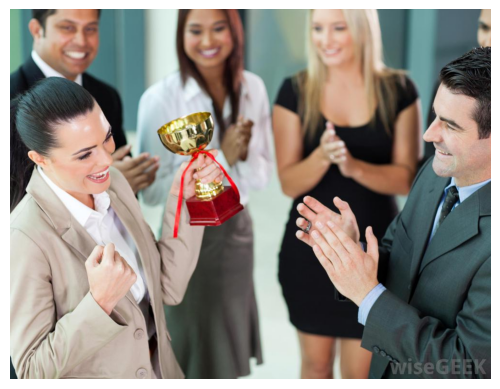

In [935]:
show_image(df_train, 46)

In [936]:
def test_query_face(i, subset, face):
    sub_images = [Term(f"face_{x}") for x in range(3)]
    images = [
        Term("tensor", Term(f"{subset}_faces", Constant(i), Constant(x)))
        for x in range(3)
    ]

    sub = {sub_images[x]: images[x] for x in range(3)}

    face_tensor = torch.load(os.path.join(findingemo_dir, "faces_tensors", subset, f"{i}_{face}.pt"))

    display_tensor_as_image(face_tensor)

    query = Query(
        query=Term(f"face_emotion_{face}", 
                    list2term(sub_images),
                    Var("Emotion")),
        substitution=sub
    )

    results = model.solve([query])
    result = results[0].result

    for key, value in sorted(result.items(), key=lambda kv: kv[1].item(), reverse=True):
        emotion = key.args[1]
        prob = value.item()
        print(f"{emotion}: {prob:.4f}")

In [937]:
face_model_truncated.eval()
scene_model_truncated.eval()

TruncatedSceneModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

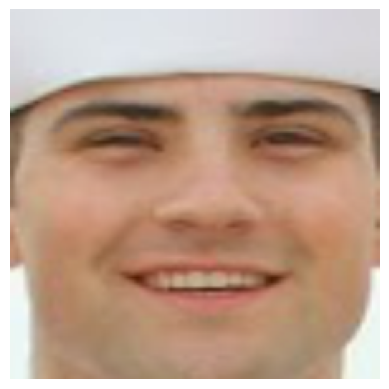

happy: 0.9967
sad: 0.0019
disgust: 0.0005
surprise: 0.0004
angry: 0.0003
fear: 0.0003


In [938]:
test_query_face(np.random.randint(0, len(df_train)), "train", np.random.randint(1,3))

Scene index: 1237


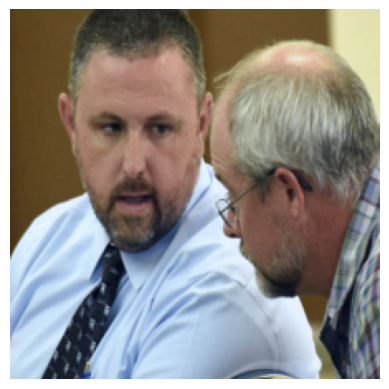

Mapped results: 
------------
'indoor_institutional': 0.9931
'industrial_facility': 0.0041
'indoor_commercial': 0.0014
'cultural_space': 0.0005
'sports_and_entertainment': 0.0002
'indoor_residential': 0.0002
'rural_or_recreational_area': 0.0002
'transport_infrastructure': 0.0001
'natural_landscape': 0.0001
'urban_outdoor': 0.0000
'aquatic_environment': 0.0000
'religious_or_historical_site': 0.0000
'cold_environment': 0.0000

Original results
------------
nursing_home (-> indoor_institutional): 0.9041
conference_center (-> indoor_institutional): 0.0318
veterinarians_office (-> indoor_institutional): 0.0213
biology_laboratory (-> indoor_institutional): 0.0100
office (-> indoor_institutional): 0.0065
hospital_room (-> indoor_institutional): 0.0043
army_base (-> industrial_facility): 0.0040
chemistry_lab (-> indoor_institutional): 0.0032
physics_laboratory (-> indoor_institutional): 0.0031
clean_room (-> indoor_institutional): 0.0026


In [1005]:
def test_query_scene(i, sceneds, subset):
    print("Scene index:", i)
    scene_tensor = sceneds[i]

    display_tensor_as_image(scene_tensor)

    query = Query(
        query=Term(f"scene_context", 
                    Term("tensor", Term(f"{subset}_scene", Constant(i))),
                    Var("Context")),
                    substitution={}
    )

    results = model.solve([query])
    result = results[0].result

    print("Mapped results: ")
    print("------------")
    for key, value in sorted(result.items(), key=lambda kv: kv[1].item(), reverse=True):
        context = key.args[1]
        prob = value.item()
        print(f"{context}: {prob:.4f}")
    print("")
    print("Original results")
    print("------------")
    scene_tensor = scene_tensor.unsqueeze(0).to(device)
    logits365 = scene_model(scene_tensor)
    probs365 = torch.softmax(logits365, dim=1)
    for i in torch.topk(probs365, 10).indices[0]:
        category = scene_categories[i]
        prob = probs365[0, i].item()
        print(f"{category} (-> {places365_to_13categories[category]}): {prob:.4f}")

random_idx = np.random.randint(0, len(df_train))
# random_idx = 4035
test_query_scene(random_idx, scene_train, "train")

In [942]:
# train_model(
#     model = model,
#     loader = loader,
#     stop_condition = EpochStop(5),
#     loss_function_name = "cross_entropy"
# )